(factorial-invariance-notebook)=
# Invarianza di misura  

In [1]:
source("../_common.R")
suppressPackageStartupMessages({
    library("lavaan")
    library("semTools")
})
set.seed(42)

Gli esempi di modelli SEM che abbiamo esaminato fino ad ora sono stati calcolati all'interno di un singolo gruppo. Questi modelli hanno utilizzato come input una sola matrice di covarianza e hanno portato alla stima dei parametri del modello senza imporre restrizioni specifiche. In questo capitolo, ci occuperemo del concetto di invarianza, estendendo le analisi precedenti ad un contesto multi-gruppo.

L'invarianza in un'analisi SEM multi-gruppo può riferirsi a diversi aspetti del modello. Un approccio utile è suddividere lo studio dell'invarianza in due componenti:

1. **Invarianza nei modelli di misurazione**: si verifica se gli strumenti di misurazione sono invarianti o equivalenti tra diversi gruppi. Questo tipo di analisi testa l'uguaglianza dei parametri associati al modello di misurazione tra i gruppi, inclusi i carichi fattoriali, gli intercetti delle variabili di misura e le varianze e covarianze residue.
   
2. **Invarianza nei modelli strutturali**: si verifica se le strutture latenti sono invarianti o equivalenti tra diversi gruppi. Questa analisi testa l'uguaglianza dei parametri associati al modello di struttura latente tra i gruppi, inclusi i coefficienti di percorso, le medie e le varianze dei fattori e le covarianze tra i fattori.

In generale, nella modellazione SEM multi-gruppo si cerca di ottenere la massima parsimonia (semplicità) possibile, desiderando un grado elevato di invarianza sia nelle misure che nelle strutture. Tuttavia, i modelli invarianti sono restrittivi e comportano un compromesso tra adattamento del modello e parsimonia. Pertanto, nella pratica, il ricercatore deve trovare un equilibrio tra questi due aspetti. Di conseguenza, quando si adatta un modello multi-gruppo, si tende a scegliere modelli con un certo grado di invarianza che mantengano un adeguato adattamento del modello. Questo può significare invarianza solo nella misurazione, solo nella struttura, o in un sottoinsieme di parametri in entrambi i componenti.

Nel presente capitolo, per valutare l'invarianza di misura, utilizzeremo l'approccio dell'analisi fattoriale confermativa a gruppi multipli (MG-CFA). Esploreremo se sia sensato considerare la stessa struttura fattoriale in gruppi diversi, ossia se la stessa variabile latente viene misurata in modo equivalente tra i diversi gruppi. Questo aspetto, noto come *invarianza di misura*, è fondamentale perché permette di effettuare confronti tra le medie dei gruppi. Se un dato strumento di misura valuta dimensioni diverse in gruppi differenti, allora non è possibile fare confronti validi tra questi gruppi utilizzando quella misura. In questo capitolo, affronteremo la questione dell'invarianza di misura considerando prima gli indicatori continui e poi quelli categoriali.

## Indicatori continui

### Intercette degli item

In generale, i modelli di equazioni strutturali vengono utilizzati per modellare unicamente la matrice di covarianza delle variabili osservate in un set di dati.  Ricordiamo che, quando abbiamo introdotto il modello dell'analisi fattoriale, 

$$
y_i = \mu + \lambda_j \xi_k + \delta_i,
$$

per semplicità abbiamo ignorato la media $\mu$ degli indicatori esprimendo i dati osservati nei termini degli scarti dalla media, $y_i -\mu$, in quanto ciò lascia immutate le covarianze. Tuttavia, in alcune applicazioni (quali, appunto, l'invarianza di misura), è utile considerare anche le medie delle variabili osservate. Per includere nel modello fattoriale le informazioni sulle medie facciamo esplicito riferimento all'intercetta della precedente equazione. Usando la sintassi `lavaan`, la media di una variabile manifesta viene inserita nel modello specificando l'intercetta dell'equazione precedente come segue

In [2]:
my_item ~ 1

my_item ~ 1

La parte sinistra dell'espressione precedente contiene il nome della variabile manifesta a cui si fa riferimento; la parte destra dell'espressione precedente specifica la presenza dell'intercetta. 

Per esempio, nella specificazione di un modello a due fattori comuni, è possibile aggiungere al modello le medie delle variabili manifeste nel modo seguente:

In [3]:
mod1 <- "
  # two-factor model
  f1 =~ x1 + x2 + x3
  f2 =~ x4 + x5 + x6
  # intercepts
  x1 ~ 1
  x2 ~ 1
  x3 ~ 1
  x4 ~ 1
  x5 ~ 1
  x6 ~ 1
"

Tuttavia, è più conveniente omettere le intercette nella specificazione del modello e aggiungere l'argomento `meanstructure = TRUE` nella funzione `cfa()`.

In [4]:
mod2 <- "
  f1 =~ x1 + x2 + x3
  f2 =~ x4 + x5 + x6
"

```
fit <- cfa(
  mod2,
  data = d,
  meanstructure = TRUE
)
```

Si noti che modelli con o senza `meanstructure` avranno la stessa statistica chi-quadrato e lo stesso numero di gradi di libertà. Il motivo è che, nel caso di un modello con `meanstructure`, vengono introdotti $p$ nuovi dati (ovvero, il valore della media per ciascuno dei $p$ indicatori) ma vengono anche stimati ulteriori $p$ parametri (ovvero, un'intercetta per ciascuno dei $p$ indicatori). Il risultato finale è che la bontà dell'adattamento resta immutata. In pratica, l'unico motivo per aggiungere le intercette nella sintassi del modello è quello di introdurre dei vincoli nella stima di tali parametri. 

### Tipologie di Invarianza 

È possibile definire diversi livelli di invarianza tra gruppi nel contesto di un'analisi fattoriale confermativa (CFA) multigruppo:

1. **Invarianza Configurale (fit_ef)**: Questo è il livello più basilare di invarianza. Si verifica quando la stessa struttura fattoriale si adatta a ogni gruppo. Questo significa che gli stessi fattori sono presenti in ogni gruppo e che gli stessi item misurano questi fattori in tutti i gruppi. Non si assumono ancora uguaglianze nelle saturazioni fattoriali o in altri parametri del modello.

2. **Invarianza Metrica (fit_efl)**: Oltre all'invarianza configurale, si testa l'uguaglianza delle saturazioni fattoriali ("loadings") attraverso i gruppi. Questo passo verifica se gli item hanno lo stesso rapporto con il fattore latente in tutti i gruppi. L'invarianza metrica è fondamentale per affermare che la scala del fattore latente è la stessa tra i gruppi.

3. **Invarianza delle Intercette degli Indicatori (fit_eii)**: A questo livello, si testa se le intercette degli item sono uguali tra i gruppi, oltre all'uguaglianza delle saturazioni fattoriali. Questo passo è cruciale per sostenere che i gruppi interpretano il significato dei punteggi degli item allo stesso modo.

4. **Invarianza delle Varianze degli Errori degli Indicatori (fit_eir)**: Qui si aggiunge il test sull'uguaglianza delle varianze degli errori degli indicatori tra i gruppi. Questo implica che l'affidabilità di ciascun item (in termini di errore di misurazione) è la stessa in tutti i gruppi.

5. **Invarianza delle Varianze dei Fattori Latenti (fit_fv)**: In questo modello, si testa l'uguaglianza delle varianze dei fattori latenti tra i gruppi, oltre ai livelli precedenti di invarianza. Questo indica che la variabilità dei fattori latenti è simile tra i gruppi.

6. **Invarianza delle Medie dei Fattori Latenti (fit_fm)**: Questo è il livello più stringente di invarianza, dove si testa anche l'uguaglianza delle medie dei fattori latenti tra i gruppi. Questo significa che non solo la struttura e il funzionamento del modello sono simili tra i gruppi, ma anche che i gruppi hanno medie latenti equivalenti.

Ogni livello successivo di invarianza include i vincoli del livello precedente. Il passaggio da un livello all'altro richiede un confronto degli indici di adattamento per determinare se l'aggiunta di nuovi vincoli peggiora significativamente l'adattamento del modello. Questa sequenza di modelli aiuta a comprendere in modo rigoroso se e come un costrutto misurato dal modello CFA si manifesti in modo simile o diverso tra i gruppi.


### Un esempio concreto

Consideriamo qui un esempio discusso da {cite:t}`brown2015confirmatory`. Il modello CFA riguarda un modello di misurazione per la depressione maggiore così come è definita nel DSM-IV. Il campione include 9 indicatori:

- MDD1, depressed mood; 
- MDD2, loss of interest in usual activities; 
- MDD3, weight/appetite change; 
- MDD4, sleep disturbance; 
- MDD5, psychomotor agitation/retardation; 
- MDD6, fatigue/loss of energy; 
- MDD7, feelings of worthlessness/guilt; 
- MDD8, concentration difficulties; 
- MDD9, thoughts of death/suicidality.

Leggiamo i dati in $\mathsf{R}$:

In [5]:
d <- readRDS(
  here::here("data", "mdd_sex.RDS")
)

In [6]:
head(d)

,sex,mdd1,mdd2,mdd3,mdd4,mdd5,mdd6,mdd7,mdd8,mdd9
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,female,5,4,1,6,5,6,5,4,2
2,female,5,5,5,5,4,5,4,5,4
3,female,4,5,4,2,6,6,0,0,0
4,female,5,5,3,3,5,5,6,4,0
5,female,5,5,0,5,0,4,6,0,0
6,female,6,6,4,6,4,6,5,6,2


Nel caso presente, i gruppi corrispondono al genere. Confrontiamo le distribuzioni di densità empirica degli item tra i due gruppi.

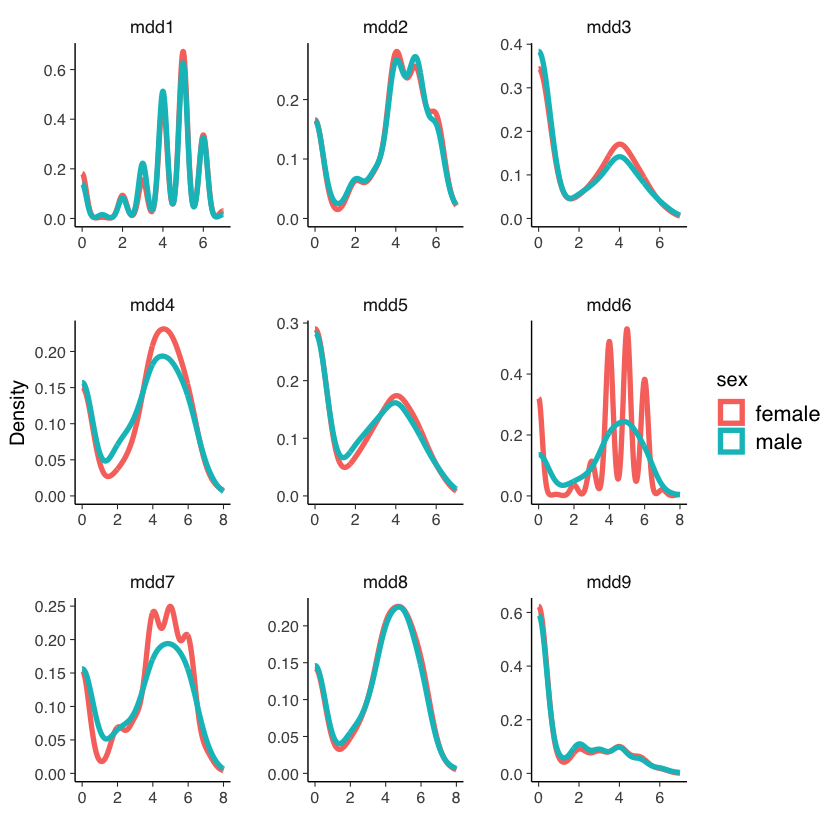

In [7]:
d_long <- d |>
    pivot_longer(!sex, names_to = "item", values_to = "value")

d_long |>
    ggplot(aes(value, col=sex)) +
    geom_density(linewidth=1.5) +
    facet_wrap(~item, nrow=3, scales="free") +
    labs(x=" ", y="Density")

Ci poniamo dunque il problema di stabilire l'invarianza fattoriale in funzione del genere. Consideriamo il seguente modello:

In [8]:
model_mdd <- "
  MDD =~ mdd1 + mdd2 + mdd3 + mdd4 + mdd5 + mdd6 + mdd7 + mdd8 +
         mdd9
  mdd1 ~~ mdd2
"

Si noti la presenza di una correlazione residua tra gli indicatori `mdd1` e `mdd2`.

In precedenza, abbiamo discusso le strutture di media e covarianza dei modelli CFA nel contesto di un'analisi a singolo gruppo. La stima dei parametri del modello, data un campione, può essere effettuata selezionando o individuando il miglior insieme di stime che minimizza una funzione di discrepanza.

L'estensione di questo metodo di stima per un singolo campione all'analisi CFA multi-gruppo è diretta. Prima di tutto, si definisce una funzione di discrepanza individuale per ogni gruppo o campione. Per stimare tutti i parametri in gruppi indipendenti simultaneamente, si definisce una funzione di discrepanza complessiva come somma ponderata delle funzioni di discrepanza specifiche per gruppo.

Procediamo quindi con la definizione di modelli che facilitano il confronto tra diversi tipi di invarianza fattoriale. È importante prestare attenzione ai vincoli che vengono progressivamente introdotti man mano che si specificano modelli sempre più restrittivi. Nella sintassi del software `lavaan`, utilizzato per l'analisi SEM, questi vincoli vengono impostati tramite l'argomento `group.equal`.

In [9]:
# configural invariance
fit_ef <- cfa(
  model_mdd,
  data = d,
  group = "sex",
  meanstructure = TRUE
)

# plus equal factor loadings- metric invariance
fit_efl <- update(
  fit_ef,
  group.equal = c("loadings")
)

# plus equal indicator intercepts
fit_eii <- update(
  fit_efl,
  group.equal = c("loadings", "intercepts")
)

# plus equal indicator error variances
fit_eir <- update(
  fit_eii,
  group.equal = c("loadings", "intercepts", "residuals")
)

# plus equal factor variances
fit_fv <- update(
  fit_eir,
  group.equal = c(
    "loadings", "intercepts", "residuals",
    "lv.variances"
  )
)

# plus equal latent means
fit_fm <- update(
  fit_fv,
  group.equal = c(
    "loadings", "intercepts", "residuals",
    "lv.variances", "means"
  )
)

Confrontiamo i modelli mediate il test del rapporto di verosimiglianze:

In [10]:
out <- lavTestLRT(fit_ef, fit_efl, fit_eii, fit_eir, fit_fv, fit_fm)
print(out)


Chi-Squared Difference Test

        Df   AIC   BIC   Chisq Chisq diff    RMSEA Df diff Pr(>Chisq)
fit_ef  52 27526 27784  98.911                                       
fit_efl 60 27514 27736 102.839     3.9286 0.000000       8     0.8635
fit_eii 68 27510 27695 115.309    12.4699 0.038600       8     0.1314
fit_eir 77 27502 27645 125.021     9.7115 0.014520       9     0.3743
fit_fv  78 27501 27639 125.814     0.7931 0.000000       1     0.3732
fit_fm  79 27501 27635 127.734     1.9201 0.049533       1     0.1659


Il confronto tra i precedenti modelli nidificati che introducono vincoli sempre più stringenti sui parametri indica che non vi è una "significativa" perdita di bontà dell'adattamento passando dal modello congenerico al modello che assume l'uguaglianza delle saturazioni fattoriali, delle intercette, delle varianze residue, delle varianze delle variabili latenti e delle medie dei due gruppi. Per i dati discussi da {cite:t}`brown2015confirmatory`, dunque, possiamo concludere che vi sono forti evidenze di invarianza fattoriale tra maschi e femmine in relazione al costrutto di depressione maggiore. L'invarianza fattoriali giustifica, per questi dati, un confronto tra le medie dei punteggi totali del test calcolate nei due gruppi.


## Indicatori a livello di scala ordinale

Nell'analisi multi-gruppo per dati ordinali devono essere affrontati problemi specifici per questo tipo di dati. I dati ordinali si distinguono dalle variabili continue in due modi principali: per il metodo utilizzato nella stima delle saturazioni fattoriali e per l'approccio nell'analisi statistica.

Le variabili ordinali sono formate da categorie con un ordine logico. Ad esempio, risposte come "fortemente in disaccordo" fino a "fortemente d'accordo", o "mai", "a volte", "spesso", "sempre" sono sequenze logiche. Sebbene queste categorie siano ordinate, la distanza tra di loro non è necessariamente uniforme o misurabile in termini quantitativi. Pertanto, assegnare valori numerici a queste risposte è un processo arbitrario e non riflette differenze di intensità o grandezza.

Uno dei problemi principali nell'analizzare dati ordinali è come calcolare le correlazioni. Le correlazioni policoriche offrono una soluzione, presupponendo l'esistenza di una variabile latente continua e normalmente distribuita che influisce sulla distribuzione delle risposte. In questo modello, ogni categoria di risposta ordinale corrisponde a un intervallo specifico sulla variabile latente sottostante. I punti di taglio o soglie ($\tau_1, \tau_2, \dots, \tau_k$) dividono la distribuzione normale in sezioni che rappresentano le frequenze osservate per ogni categoria.

Nell'ambito dell'invarianza fattoriale per dati ordinali, si pone inizialmente la questione dell'invarianza delle soglie (treshold invariance). Questo concetto presuppone che le soglie che definiscono le correlazioni policoriche rimangano costanti tra i gruppi. La stabilità di queste soglie è fondamentale per assicurare che le relazioni tra le categorie di risposta siano comparabili tra diversi gruppi.

Un secondo aspetto cruciale è la scelta dello stimatore per la stima delle saturazioni fattoriali. Per i dati ordinali, lo stimatore raccomandato è quello dei minimi quadrati ponderati (Weighted Least Squares, WLS). Questo metodo è preferito perché tiene conto della natura specifica dei dati ordinali, fornendo stime più accurate e affidabili delle saturazioni fattoriali rispetto a metodi pensati per dati continui.

In sintesi, l'analisi di invarianza fattoriale con dati ordinali richiede considerazioni e tecniche specifiche, che includono l'utilizzo di correlazioni policoriche e l'impiego di stimatori adeguati, per garantire risultati validi e interpretabili.

### Un esempio concreto

{cite:t}`wu2016identification` sostengono che la metodologia convenzionale per valutare l'invarianza fattoriale nei dati continui richiede adattamenti significativi quando applicata a indicatori categoriali. Il processo standard inizia con la definizione di un modello di base, seguito dall'applicazione di restrizioni incrementali ai parametri. Tuttavia, secondo {cite:t}`wu2016identification`, questo approccio risulta subottimale per i dati categoriali, a causa della sua dipendenza critica dalla definizione delle soglie utilizzate per stabilire le correlazioni policoriche con le variabili latenti continue nel modello configurale.

{cite:t}`wu2016identification` enfatizzano che, in contesti con dati categoriali, è primario valutare prima l'equivalenza delle soglie tra i gruppi, definendo ciò che viene chiamato un "modello di soglia" (threshold model). Solo dopo questa valutazione preliminare è consigliabile procedere con l'analisi dell'equivalenza delle saturazioni fattoriali tra i gruppi. Questo cambiamento nell'ordine di valutazione è cruciale per garantire che le soglie, che sono fondamentali per la definizione delle correlazioni policoriche nei dati categoriali, siano coerenti e comparabili tra i gruppi prima di procedere con ulteriori analisi sull'invarianza fattoriale. In sostanza, ciò che {cite:t}`wu2016identification` propongono è una riconsiderazione della sequenza di passaggi nell'analisi dell'invarianza per dati categoriali, ponendo una maggiore enfasi sull'allineamento delle soglie prima di esplorare altre forme di equivalenza nei modelli multigruppo.

Per illustrare tale procedura, replichiamo qui il tutorial messo a punto da {cite:t}`svetina2020multiple`. Questi autori utilizzano quattro item di una scala del bullismo ed esaminano i dati raccolti in tre paesi (31 = Azerbaigian; 40 = Austria; 246 = Finlandia). Tutti gli item sono misurati su una scala di tipo Likert a 4 punti, che va da 0 (mai) a 3 (almeno una volta alla settimana). Gli item chiedono al partecipante di valutare delle affermazioni relative ad episodi di bullismo. Per esempio, "mi prendevano in giro o mi insultavano". Per l'Azerbaigian, l'Austria e la Finlandia, le dimensioni del campione sono rispettivamente pari a 3,808, 4,457 e 4,520. 

Leggiamo in dati in $\textsf{R}$:

In [11]:
dat <- read.table("data/BULLY.dat", header = FALSE)
names(dat) <- c("IDCNTRY", "R09A", "R09B", "R09C", "R09D")
head(dat)

Warning message in file(file, "rt"):
“non è possibile aprire il file 'data/BULLY.dat': No such file or directory”


ERROR: Error in file(file, "rt"): non è possibile aprire la connessione


Viene creata la matrice `all.results` per immagazzinare i risultati dei diversi modelli che verranno confrontati, chiamati _baseline_ (nessun vincolo tra i gruppi), _proposition 4_ (equivalenza delle soglie tra i gruppi), e _proposition 7_ (equivalenza delle soglie e delle saturazioni fattoriali tra i gruppi). Gli indici di bontà dell'adattamento che verranno considerati sono: chi-square, df, p, RMSEA, CFI, e TLI. 

In [15]:
all.results <- matrix(NA, ncol = 6, nrow = 3)

### Baseline model

Nel _baseline model_ non viene posto alcun vincolo tra i gruppi. È quello dell'invarianza configurale.

In [16]:
mod.cat <- "F1 =~ R09A + R09B + R09C + R09D"

In [17]:
baseline <- measEq.syntax(
  configural.model = mod.cat,
  data = dat,
  ordered = c("R09A", "R09B", "R09C", "R09D"),
  parameterization = "delta",
  ID.fac = "std.lv",
  ID.cat = "Wu.Estabrook.2016",
  group = "IDCNTRY",
  group.equal = "configural"
)

Informazioni sul modello baseline si ottengono nel modo seguente:

In [18]:
out <- summary(baseline)
print(out)

This lavaan model syntax specifies a CFA with 4 manifest indicators (4 of which are ordinal) of 1 common factor(s).

To identify the location and scale of each common factor, the factor means and variances were fixed to 0 and 1, respectively, unless equality constraints on measurement parameters allow them to be freed.

The location and scale of each latent item-response underlying 4 ordinal indicators were identified using the "delta" parameterization, and the identification constraints recommended by Wu & Estabrook (2016). For details, read:

	https://doi.org/10.1007/s11336-016-9506-0 

Pattern matrix indicating num(eric), ord(ered), and lat(ent) indicators per factor:

     F1 
R09A ord
R09B ord
R09C ord
R09D ord

The following types of parameter were constrained to equality across groups:

	configural

     F1   
R09A "ord"
R09B "ord"
R09C "ord"
R09D "ord"


Le proprietà del modello possono essere esplicitate con la seguente istruzione:

In [19]:
cat(as.character(baseline))

## LOADINGS:

F1 =~ c(NA, NA, NA)*R09A + c(lambda.1_1.g1, lambda.1_1.g2, lambda.1_1.g3)*R09A
F1 =~ c(NA, NA, NA)*R09B + c(lambda.2_1.g1, lambda.2_1.g2, lambda.2_1.g3)*R09B
F1 =~ c(NA, NA, NA)*R09C + c(lambda.3_1.g1, lambda.3_1.g2, lambda.3_1.g3)*R09C
F1 =~ c(NA, NA, NA)*R09D + c(lambda.4_1.g1, lambda.4_1.g2, lambda.4_1.g3)*R09D

## THRESHOLDS:

R09A | c(NA, NA, NA)*t1 + c(R09A.thr1.g1, R09A.thr1.g2, R09A.thr1.g3)*t1
R09A | c(NA, NA, NA)*t2 + c(R09A.thr2.g1, R09A.thr2.g2, R09A.thr2.g3)*t2
R09A | c(NA, NA, NA)*t3 + c(R09A.thr3.g1, R09A.thr3.g2, R09A.thr3.g3)*t3
R09B | c(NA, NA, NA)*t1 + c(R09B.thr1.g1, R09B.thr1.g2, R09B.thr1.g3)*t1
R09B | c(NA, NA, NA)*t2 + c(R09B.thr2.g1, R09B.thr2.g2, R09B.thr2.g3)*t2
R09B | c(NA, NA, NA)*t3 + c(R09B.thr3.g1, R09B.thr3.g2, R09B.thr3.g3)*t3
R09C | c(NA, NA, NA)*t1 + c(R09C.thr1.g1, R09C.thr1.g2, R09C.thr1.g3)*t1
R09C | c(NA, NA, NA)*t2 + c(R09C.thr2.g1, R09C.thr2.g2, R09C.thr2.g3)*t2
R09C | c(NA, NA, NA)*t3 + c(R09C.thr3.g1, R09C.thr3.g2, R09C.thr3.g3)

Per potere essere passato a `lavaan`, l'oggetto `baseline` deve essere in formato `char`:

In [20]:
model.baseline <- as.character(baseline)

Adattiamo il modello ai dati:

In [21]:
fit.baseline <- cfa(
  model.baseline, 
  data = dat, 
  group = "IDCNTRY", 
  ordered = c("R09A", "R09B", "R09C", "R09D")
)

Salviamo i risultati:

In [22]:
all.results[1, ] <-
  round(
    data.matrix(
      fitmeasures(fit.baseline, fit.measures = c(
        "chisq.scaled", "df.scaled", "pvalue.scaled",
        "rmsea.scaled", "cfi.scaled", "tli.scaled"
      ))
    ),
    digits = 3
  )

### Invarianza delle soglie

Consideriamo ora il modello _threshold invariance_ [chiamato _Proposition 4_ da @wu2016identification]. 

In [23]:
prop4 <- measEq.syntax(
  configural.model = mod.cat,
  data = dat,
  ordered = c("R09A", "R09B", "R09C", "R09D"),
  parameterization = "delta",
  ID.fac = "std.lv",
  ID.cat = "Wu.Estabrook.2016",
  group = "IDCNTRY",
  group.equal = c("thresholds")
)

Adattiamo il modello ai dati:

In [24]:
model.prop4 <- as.character(prop4)
fit.prop4 <- cfa(
  model.prop4,
  data = dat,
  group = "IDCNTRY",
  ordered = c("R09A", "R09B", "R09C", "R09D")
)

Salviamo i risulati

In [25]:
#store model fit information for proposition 4
all.results[2, ] <-
  round(data.matrix(
  fitmeasures(fit.prop4,fit.measures = c(
    "chisq.scaled","df.scaled","pvalue.scaled", 
    "rmsea.scaled", "cfi.scaled", "tli.scaled"))), 
  digits=3
  )

Eseguiamo il confronto tra il modello _threshold invariance_ e il modello _baseline_:

In [26]:
lavTestLRT(fit.baseline, fit.prop4)

,Df,AIC,BIC,Chisq,Chisq diff,Df diff,Pr(>Chisq)
,<int>,<lgl>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
fit.baseline,6,NA,NA,26.94149,NA,NA,NA
fit.prop4,14,NA,NA,42.16983,61.01121,8,2.950764e-10


### Invarianza delle soglie e delle saturazioni fattoriali

Consideriamo ora il modello _threshold and loading invariance_ [chiamato _Proposition 7_ da @wu2016identification]. 

In [27]:
prop7 <- measEq.syntax(
  configural.model = mod.cat,
  data = dat,
  ordered = c("R09A", "R09B", "R09C", "R09D"),
  parameterization = "delta",
  ID.fac = "std.lv",
  ID.cat = "Wu.Estabrook.2016",
  group = "IDCNTRY",
  group.equal = c("thresholds", "loadings")
)

Adattiamo il modello ai dati:

In [33]:
model.prop7 <- as.character(prop7)
fit.prop7 <- cfa(
  model.prop7, 
  data = dat, group = "IDCNTRY", 
  ordered = c("R09A", "R09B", "R09C", "R09D")
  )

Salviamo i risultati:

In [34]:
all.results[3, ] <-
  round(data.matrix(
    fitmeasures(fit.prop7, fit.measures = c(
      "chisq.scaled", "df.scaled", "pvalue.scaled",
      "rmsea.scaled", "cfi.scaled", "tli.scaled"
    ))
  ), digits = 3)

column.names <-
  c(
    "chisq.scaled", "df.scaled", "pvalue.scaled", "rmsea.scaled",
    "cfi.scaled", "tli.scaled"
  )

row.names <- c("baseline", "prop4", "prop7")

colnames(all.results) <- column.names
rownames(all.results) <- row.names

Eseguiamo i confronti tra modelli:

In [35]:
lavTestLRT(fit.prop4, fit.prop7)

,Df,AIC,BIC,Chisq,Chisq diff,Df diff,Pr(>Chisq)
,<int>,<lgl>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
fit.prop4,14,NA,NA,42.16983,NA,NA,NA
fit.prop7,20,NA,NA,93.11534,73.70792,6,7.079865e-14


In [36]:
lavTestLRT(fit.prop7, fit.baseline)

,Df,AIC,BIC,Chisq,Chisq diff,Df diff,Pr(>Chisq)
,<int>,<lgl>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
fit.baseline,6,NA,NA,26.94149,NA,NA,NA
fit.prop7,20,NA,NA,93.11534,136.1424,14,4.139318e-22


Un confronto tra gli indici di bontà di adattamento dei tre modelli è fornito di seguito:

In [37]:
print(all.results)

         chisq.scaled df.scaled pvalue.scaled rmsea.scaled cfi.scaled
baseline       50.944         6             0        0.042      0.997
prop4         107.839        14             0        0.040      0.994
prop7         186.542        20             0        0.044      0.989
         tli.scaled
baseline      0.991
prop4         0.992
prop7         0.990


In conclusione, nel caso presente, il test del rapporto di verosimiglianza indica che non viene rispettata neppure l'invarianza delle soglie tra gruppi. Gli altri confronti, dunque, sono superflui e sono stati qui presentati solo allo scopo di illustrare la procedura.







## Vincoli Inter-gruppi

Quando si adatta un modello di equazioni strutturali ai dati provenienti da più gruppi, è comune imporre vincoli di uguaglianza inter-gruppi su certe stime di parametri non standardizzati. Questi parametri possono riguardare effetti causali, inclusi effetti diretti, indiretti o totali, o per varianze, covarianze, medie o intercette. La scelta tra questi dovrebbe essere correlata a specifiche ipotesi riguardo le differenze tra i gruppi. Se l'adattamento del modello vincolato è molto peggiore rispetto a quello del modello non vincolato—e il modello non vincolato si adatta bene ai dati—possiamo concludere che le popolazioni da cui sono stati selezionati i gruppi possono differire rispetto ai parametri soggetti a vincoli di uguaglianza. Un'alternativa all'analisi multi-gruppo consiste nel rappresentare l'appartenenza al gruppo in un modello a singolo gruppo, adattato ai dati di tutti i gruppi combinati. Alcune variabili endogene nel modello sono regresse sul gruppo e su termini prodotto che coinvolgono il gruppo e altre variabili moderatrici presunte. I coefficienti per i termini prodotto stimano gli effetti interattivi del gruppo con altre variabili causali, e i loro valori possono essere convertiti in stime di effetti indiretti condizionali. Un inconveniente è che i modelli a singolo gruppo generalmente assumono l'omoscedasticità tra i gruppi, e le stime possono essere inesatte se tali assunzioni sono insostenibili. In contrasto, è semplice testare le ipotesi di omogeneità in un approccio multi-gruppo.

Esaminiamo un esempio discuso da {cite:t}`kline2023principles`. Lynam e colleghi (1993) hanno misurato lo status socioeconomico familiare (SES), il quoziente intellettivo verbale (QI verbale), la motivazione dell'esaminato durante il test del QI, il rendimento scolastico e i comportamenti delinquenzali in campioni di adolescenti maschi bianchi (n = 181) e neri (n = 214) di età compresa tra i 12 e i 13 anni. Erano studenti di quarta elementare in scuole pubbliche urbane negli Stati Uniti ed erano parte di uno studio longitudinale su individui ad alto rischio di forme precoci di delinquenza. 

La figura mostra un modello di percorso con una struttura di media (rappresentata con linee tratteggiate) basato sulle variabili dello studio. La figura rappresenta l'ipotesi che SES, motivazione e QI verbale siano cause correlate che influenzano la delinquenza sia direttamente che indirettamente attraverso il rendimento scolastico. Ad esempio, i ragazzi adolescenti con scarsa abilità verbale potrebbero essere più propensi ad abbandonare la scuola, contribuendo così alla delinquenza a causa di prospettive di impiego ridotte o del maggiore tempo non supervisionato per strada.

```{figure} images/lynam.png
---
height: 450px
name: path_01-fig
---
Diagramma di percorso proposto da Lynam et al. (1993).
```

Lo studio di Lynam et al. (1993) era trasversale, senza precedenza temporale nelle misurazioni, quindi l'unica base per la specificazione della direzionalità è l'argomentazione. La logica appena riassunta è soggetta a critiche. Ad esempio, Block (1995) ha sostenuto che Lynam et al. (1993) hanno trascurato il ruolo potenziale dell'impulsività come mediatore degli effetti dell'abilità verbale sulla delinquenza. Ovvero, Block (1995) ha sostenuto che non è l'abilità verbale compromessa di per sé che è causalmente correlata alla delinquenza; piuttosto, una capacità ridotta di ritardare la gratificazione, pensare prima di agire o rimanere concentrati su un obiettivo sono fattori più importanti nella delinquenza. 

1. Senza vincoli, il modello di percorso nella figura è "appena identificato" (*just identified*) e si adatterebbe perfettamente ai dati in entrambi i gruppi. Vincoli di uguaglianza inter-gruppi sono stati imposti su parametri chiave in questo esempio per testare l'ipotesi che rimanere a scuola sia un fattore protettivo relativamente più forte contro la delinquenza tra i giovani maschi neri rispetto ai giovani maschi bianchi, specialmente in aree urbane a basso SES con relativamente più famiglie monogenitoriali dove i giovani neri sono rappresentati sproporzionatamente (Lynam et al., 1993). La strategia di analisi è delineata di seguito: per il modello 1, tutti i 7 effetti diretti non standardizzati sono vincolati all'uguaglianza nei due gruppi. Ci si aspettava che il modello 1 fosse incoerente con i dati, se l'effetto del rendimento scolastico sull'illegalità è diverso tra i gruppi.
2. Per il modello 2, il vincolo di uguaglianza per l'effetto diretto del rendimento sulla delinquenza è rilasciato, ciò che ci si aspettava migliorasse notevolmente l'adattamento rispetto a quello del modello 1.
3. Assumendo un adattamento globale e locale soddisfacente del modello 2 in entrambi i gruppi, vengono testati due modelli aggiuntivi. Per il modello 3, l'intercetta per la regressione del rendimento su SES, sforzo nel test e QI verbale è vincolata all'uguaglianza
4. Modello 4: l'intercetta per la regressione della delinquenza su SES, sforzo nel test, QI verbale e rendimento è vincolata all'uguaglianza. Il confronto degli adattamenti relativi dei modelli 3 e 4 con il modello 2 testa l'uguaglianza delle intercette di regressione per le variabili endogene tra i gruppi.

Specifichiamo i dati.

In [26]:
# black, n = 214
# white, n = 181
# input the correlations in lower diagnonal form

blackLower.cor <- "
 1.00
  .08 1.00
  .28  .30 1.00
  .05  .21  .50 1.00
 -.11 -.17 -.26 -.33 1.00 "

whiteLower.cor <- "
 1.00
  .25 1.00
  .37  .40 1.00
  .27  .28  .61 1.00
 -.11 -.20 -.31 -.21 1.00 "

# name the variables and convert to full correlation matrix
black.cor <- lavaan::getCov(blackLower.cor, names = c(
    "ses", "effort", "viq",
    "achieve", "delinq"
))
white.cor <- lavaan::getCov(whiteLower.cor, names = c(
    "ses", "effort", "viq",
    "achieve", "delinq"
))

# display the correlations
black.cor

,ses,effort,viq,achieve,delinq
ses,1.00,0.08,0.28,0.05,-0.11
effort,0.08,1.00,0.30,0.21,-0.17
viq,0.28,0.30,1.00,0.50,-0.26
achieve,0.05,0.21,0.50,1.00,-0.33
delinq,-0.11,-0.17,-0.26,-0.33,1.00


In [27]:
white.cor

,ses,effort,viq,achieve,delinq
ses,1.00,0.25,0.37,0.27,-0.11
effort,0.25,1.00,0.40,0.28,-0.20
viq,0.37,0.40,1.00,0.61,-0.31
achieve,0.27,0.28,0.61,1.00,-0.21
delinq,-0.11,-0.20,-0.31,-0.21,1.00


In [7]:
# add the standard deviations and convert to covariances
black.cov <- lavaan::cor2cov(black.cor, sds = c(10.58, 1.35, 13.62, .79, 1.63))
white.cov <- lavaan::cor2cov(white.cor, sds = c(11.53, 1.32, 16.32, .96, 1.45))

# input group means
black.mean <- c(31.96, -.01, 93.76, 2.51, 1.40)
white.mean <- c(34.64, .05, 104.18, 2.88, 1.22)

# display the covariances and means
black.cov

,ses,effort,viq,achieve,delinq
ses,111.936400,1.142640,40.347888,0.417910,-1.896994
effort,1.142640,1.822500,5.516100,0.223965,-0.374085
viq,40.347888,5.516100,185.504400,5.379900,-5.772156
achieve,0.417910,0.223965,5.379900,0.624100,-0.424941
delinq,-1.896994,-0.374085,-5.772156,-0.424941,2.656900


In [8]:
black.mean

[1] 31.96 -0.01 93.76  2.51  1.40

In [9]:
white.cov

,ses,effort,viq,achieve,delinq
ses,132.940900,3.804900,69.622752,2.988576,-1.839035
effort,3.804900,1.742400,8.616960,0.354816,-0.382800
viq,69.622752,8.616960,266.342400,9.556992,-7.335840
achieve,2.988576,0.354816,9.556992,0.921600,-0.292320
delinq,-1.839035,-0.382800,-7.335840,-0.292320,2.102500


In [10]:
white.mean

[1]  34.64   0.05 104.18   2.88   1.22

In [11]:
# specify fit statistics for abbreviated output
fit.stats <- c(
    "chisq", "df", "pvalue",
    "rmsea", "rmsea.ci.lower", "rmsea.ci.upper", "cfi", "srmr"
)

# combine covariances matrices, mean vectors, and group sizes
# into single list objects
combined.cov <- list(black = black.cov, white = white.cov)
combined.mean <- list(black = black.mean, white = white.mean)
combined.n <- list(black = 214, white = 181)

Adattiamo i quattro modelli ai dati:

In [12]:
# specify basic covariance model
lynam.model <- "
 achieve ~ ses + effort + viq
 delinq ~ achieve + ses + effort + viq "

In [13]:
# model 1
# all 7 direct effect constrained to equality
# over groups
lynam1 <- lavaan::sem(
    lynam.model,
    sample.cov = combined.cov,
    sample.mean = combined.mean, sample.nobs = combined.n,
    group.equal = c("regressions"), fixed.x = FALSE, meanstructure = TRUE
)

In [14]:
# model 2
# direct effects constrained to equality over groups
# but the constraint on achievement -> delinguency is
# released in syntax for "group.partial"
# so 6 direct effects are constrained over groups

lynam2 <- lavaan::sem(
    lynam.model,
    sample.cov = combined.cov,
    sample.mean = combined.mean, sample.nobs = combined.n,
    group.equal = c("regressions"), group.partial = c("delinq ~ achieve"),
    fixed.x = FALSE, meanstructure = TRUE
)

In [15]:
# model 3
# retained model
# 6 direct effects constrained to equality over groups
# achievement -> delinguency is a free parameter in both groups
# intercept for achievement constrained to equality

lynam3 <- lavaan::sem(lynam.model,
    sample.cov = combined.cov,
    sample.mean = combined.mean, sample.nobs = combined.n,
    group.equal = c("regressions", "intercepts"),
    group.partial = c("delinq ~ achieve", "delinq ~ 1"),
    fixed.x = FALSE, meanstructure = TRUE
)

In [16]:
# model 4
# 6 direct effects constrained to equality over groups
# achievement -> delinguency is a free parameter in both groups
# intercept for deleinquency constrained to equality

lynam4 <- lavaan::sem(lynam.model,
    sample.cov = combined.cov,
    sample.mean = combined.mean, sample.nobs = combined.n,
    group.equal = c("regressions", "intercepts"),
    group.partial = c("delinq ~ achieve", "achieve ~ 1"),
    fixed.x = FALSE, meanstructure = TRUE
)

Esaminiamo la bontà di adattamento.

In [19]:
# global fit statistics
lavaan::fitMeasures(lynam1, fit.stats) |> print()

         chisq             df         pvalue          rmsea rmsea.ci.lower 
        11.736          7.000          0.110          0.059          0.000 
rmsea.ci.upper            cfi           srmr 
         0.115          0.975          0.036 


In [20]:
lavaan::fitMeasures(lynam2, fit.stats) |> print()

         chisq             df         pvalue          rmsea rmsea.ci.lower 
         6.107          6.000          0.411          0.010          0.000 
rmsea.ci.upper            cfi           srmr 
         0.093          0.999          0.029 


In [21]:
lavaan::fitMeasures(lynam3, fit.stats) |> print()

         chisq             df         pvalue          rmsea rmsea.ci.lower 
         6.409          7.000          0.493          0.000          0.000 
rmsea.ci.upper            cfi           srmr 
         0.083          1.000          0.030 


In [22]:
lavaan::fitMeasures(lynam4, fit.stats) |> print()

         chisq             df         pvalue          rmsea rmsea.ci.lower 
        10.237          7.000          0.176          0.048          0.000 
rmsea.ci.upper            cfi           srmr 
         0.107          0.983          0.033 


Eseguiamo il test del rapporto tra verosimiglianze.

In [23]:
# chi square difference tests
lavaan::anova(lynam1, lynam2)

,Df,AIC,BIC,Chisq,Chisq diff,RMSEA,Df diff,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
lynam2,6,9850.196,9985.478,6.107287,NA,NA,NA,NA
lynam1,7,9853.825,9985.128,11.735711,5.628424,0.1530851,1,0.01767152


In [24]:
lavaan::anova(lynam2, lynam3)

,Df,AIC,BIC,Chisq,Chisq diff,RMSEA,Df diff,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
lynam2,6,9850.196,9985.478,6.107287,NA,NA,NA,NA
lynam3,7,9848.498,9979.801,6.409026,0.3017387,0,1,0.5827945


In [25]:
lavaan::anova(lynam2, lynam4)

,Df,AIC,BIC,Chisq,Chisq diff,RMSEA,Df diff,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
lynam2,6,9850.196,9985.478,6.107287,NA,NA,NA,NA
lynam4,7,9852.326,9983.629,10.236768,4.129481,0.1258788,1,0.04214226


I risultati finora descritti sono coerenti con l'ipotesi che l'effetto diretto non standardizzato del rendimento sulla delinquenza vari in base all'appartenenza al gruppo. Tuttavia, prima di stabilire una scelta definitiva per questo esempio, consideriamo due modelli aggiuntivi. Queste analisi sono più esplorative poiché i modelli di percorso di Lynam et al. (1993) non avevano strutture di media. Il modello 3, rispetto al modello 2, presenta intercette vincolate all'uguaglianza per il rendimento. Si prevedeva che vincolare questo parametro avrebbe leggermente degradato l'adattamento globale rispetto al modello 2, in cui la stessa intercetta è liberamente stimata in entrambi i gruppi. Questo perché il modello 2 con effetti diretti uguali per le cause del rendimento - SES, sforzo nel test e QI verbale - nei due gruppi è generalmente coerente con i dati. I risultati del modello 3 supportano questa previsione. 

Poiché l'intercetta per il rendimento è ugualmente vincolata nel modello 3, la sua intera struttura di media non è più solo identificata; specificamente, ha gradi di libertà (df) = 1, quindi non tutte le medie previste per le variabili endogene, rendimento e delinquenza, corrisponderanno esattamente alle loro controparti osservate. I residui delle medie per le variabili esogene - SES, sforzo nel test e QI verbale - saranno tutti uguali a zero poiché nessun vincolo ha influenzato le loro medie previste. Il modello 3 prevede quindi accuratamente covarianze e medie in entrambi i gruppi, quindi viene mantenuto.

Nel modello 4, l'intercetta per la regressione della delinquenza su SES, sforzo nel test, QI verbale e rendimento è vincolata all'uguaglianza nei gruppi più tutti gli effetti diretti eccetto quello del rendimento sulla delinquenza, che è liberamente stimato in entrambi i campioni. Poiché l'effetto diretto appena menzionato contribuisce all'intercetta per la delinquenza, si prevedeva che vincolare l'intercetta appena menzionata all'uguaglianza avrebbe peggiorato notevolmente l'adattamento rispetto al modello 2. Questa previsione è coerente con i risultati; in particolare, sebbene il modello 4 superi il test chi-quadrato, il suo adattamento è relativamente peggiore rispetto a quello del modello 2. Anche i residui per il modello 4 sono simili a quelli del modello 1; cioè, insoddisfacenti. Pertanto, il modello 4 viene rifiutato.